In [234]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML
import numpy as np
import sympy as sym
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA, ARMA
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d

def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

In [174]:
# define number of time steps to forecast
forecast_num_x = 100

# define time step
time_step = 0.01

# t minimum offset
tmin = 35

# t maximum offset
tmax = 35

In [175]:
# data for forecasting
data = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t = data['time']
# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
print(o_x)

data_matrix_x = {}
data_matrix_x['Datatime'] = t
data_matrix_x['Data x'] = o_x
data_df_x = pd.DataFrame(data_matrix_x)
data_df_x = data_df_x.set_index('Datatime')

# real data
data2 = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax-time_step*forecast_num,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t2 = data2['time']
# position
o_x2 = data2['ae483log.o_x']
o_y2 = data2['ae483log.o_y']
o_z2 = data2['ae483log.o_z']

data2_matrix_x = {}
data2_matrix_x['Datatime'] = t2
data2_matrix_x['Data x'] = o_x2
data_df2_x = pd.DataFrame(data2_matrix_x)
data_df2_x = data_df2_x.set_index('Datatime')

[-0.79274663 -0.79221764 -0.79167781 ... -0.75280359 -0.75349361
 -0.75415828]


In [176]:
data_df_x

,Data x
Datatime,
0.00,-0.792747
0.01,-0.792218
0.02,-0.791678
0.03,-0.791128
0.04,-0.790571
...,...
10.49,-0.751326
10.50,-0.752077
10.51,-0.752804


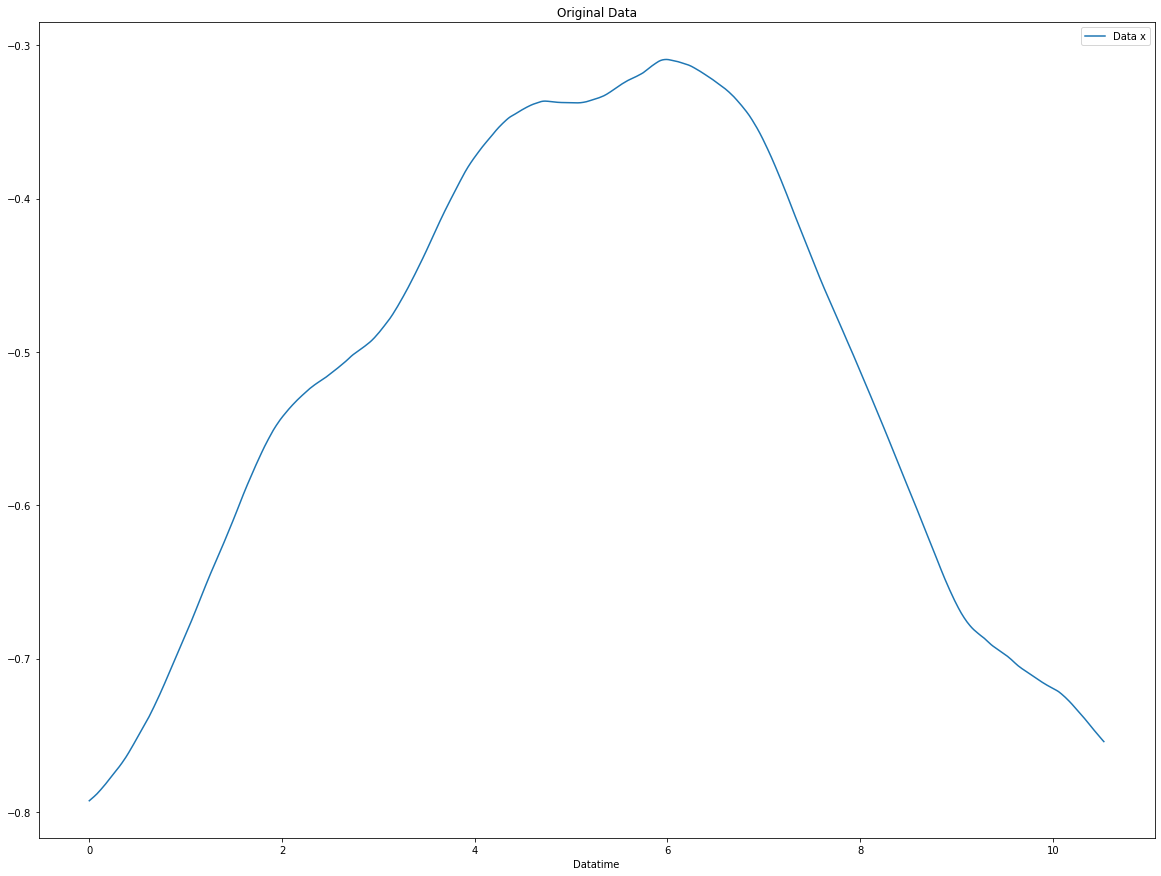

In [177]:
data_df_x.plot()
plt.title('Original Data')
plt.show()

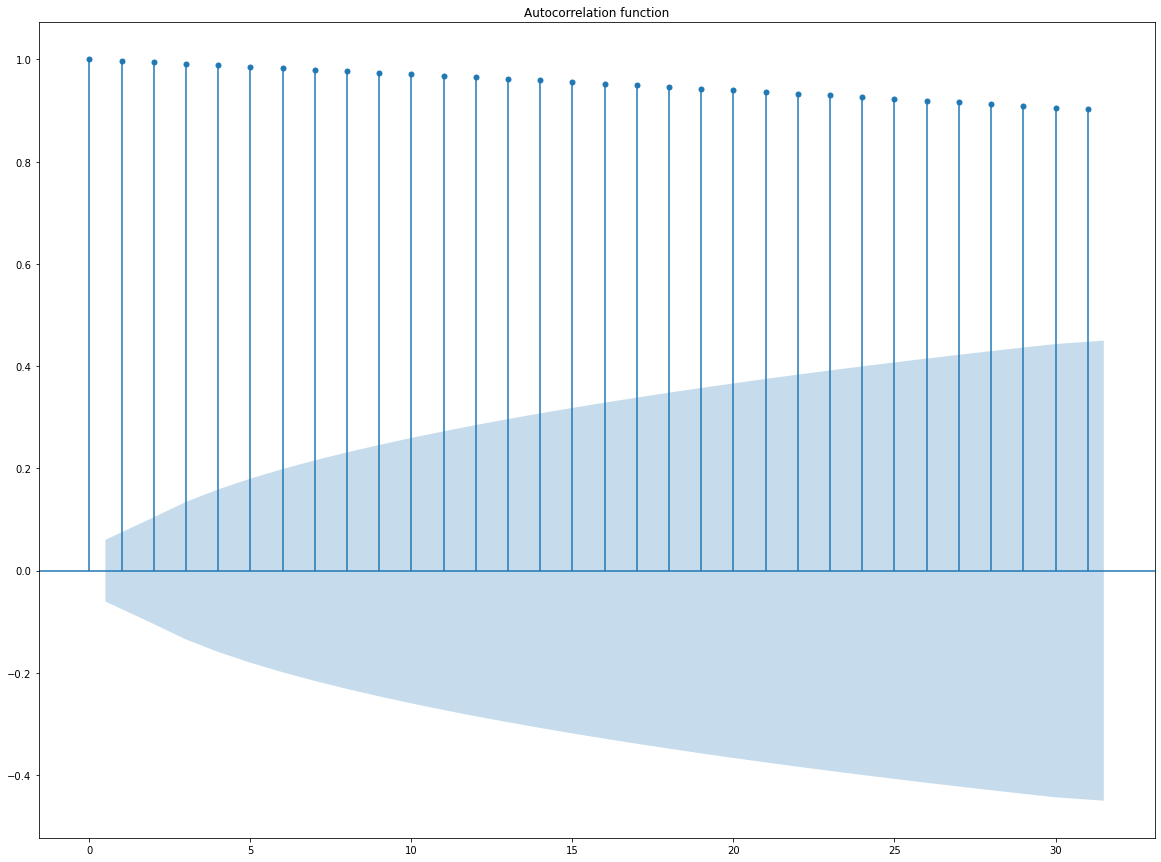

In [178]:
plot_acf(data_df_x)
plt.title('Autocorrelation function')
plt.show()

In [179]:
print(u'adf:', ADF(data_df_x[u'Data x'])[0])
print(u'pvalue:', ADF(data_df_x[u'Data x'])[1])
print(u'critical values:', ADF(data_df_x[u'Data x'])[4])

# extract stationarity check result
adf_x = ADF(data_df_x[u'Data x'])[0]
pvalue_x = ADF(data_df_x[u'Data x'])[1]
critical_values_x = ADF(data_df_x[u'Data x'])[4]
cv1_x = critical_values_x['1%']
cv5_x = critical_values_x['5%']
cv10_x = critical_values_x['10%']

adf: -2.3468163318168274
pvalue: 0.157312822194348
critical values: {'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}


In [180]:
# k is the number of difference that we need to do
k_x = 0

# define stationary check (1 means stationary, 0 means non-stationary)
stationary_check_x = 0

# keep differencing the data until it becomes stationary
D_data_x = data_df_x
while True:
    if pvalue_x >= 0.05:
        D_data_x = D_data_x.diff().dropna()
        k_x += 1
        adf_x = ADF(D_data_x[u'Data x'])[0]
        pvalue_x = ADF(D_data_x[u'Data x'])[1]
        critical_values_x = ADF(D_data_x[u'Data x'])[4]
        cv1_x = critical_values_x['1%']
        cv5_x = critical_values_x['5%']
        cv10_x = critical_values_x['10%']
        continue
    else:
        break

if k_x == 0:
    stationary_check_x = 1
    print('The orginal data is STATIONARY, no differencing needed')
    print(u'adf:', adf_x)
    print(u'pvalue:', pvalue_x)
    print(u'critical values:', critical_values_x)
else:
    stationary_check_x = 0
    print(f'The orginal data is NON-STATIONARY, need to do differencing {k} times')
    print(f'adf:', adf_x)
    print(f'pvalue:', pvalue_x)
    print(f'critical values:', critical_values_x)

The orginal data is NON-STATIONARY, need to do differencing 2 times
adf: -5.672131783173555
pvalue: 8.872427633914055e-07
critical values: {'1%': -3.4366655541494944, '5%': -2.8643284548748533, '10%': -2.5682546880209087}


            Data x
Datatime          
0.02      0.000011
0.03      0.000010
0.04      0.000007
0.05      0.000002
0.06      0.000006
...            ...
10.49     0.000002
10.50     0.000004
10.51     0.000025
10.52     0.000037
10.53     0.000025

[1052 rows x 1 columns]


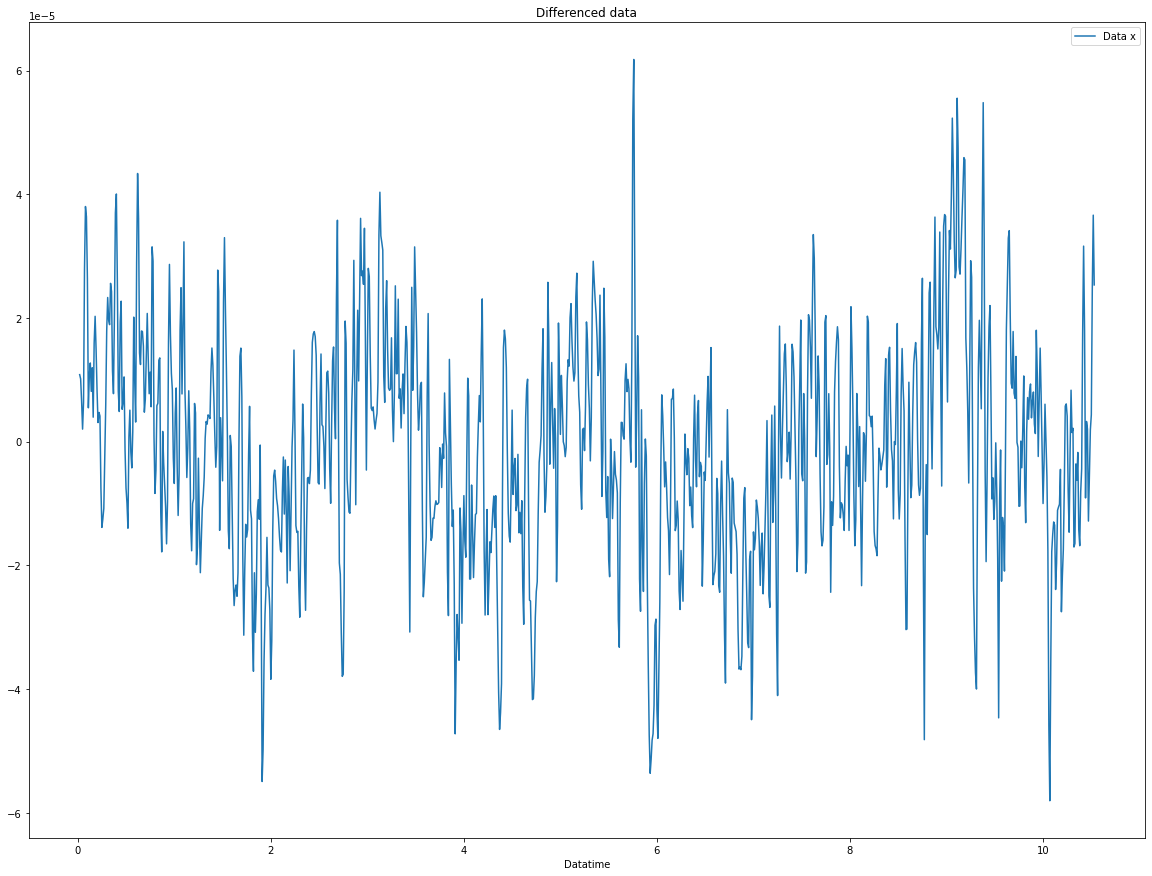

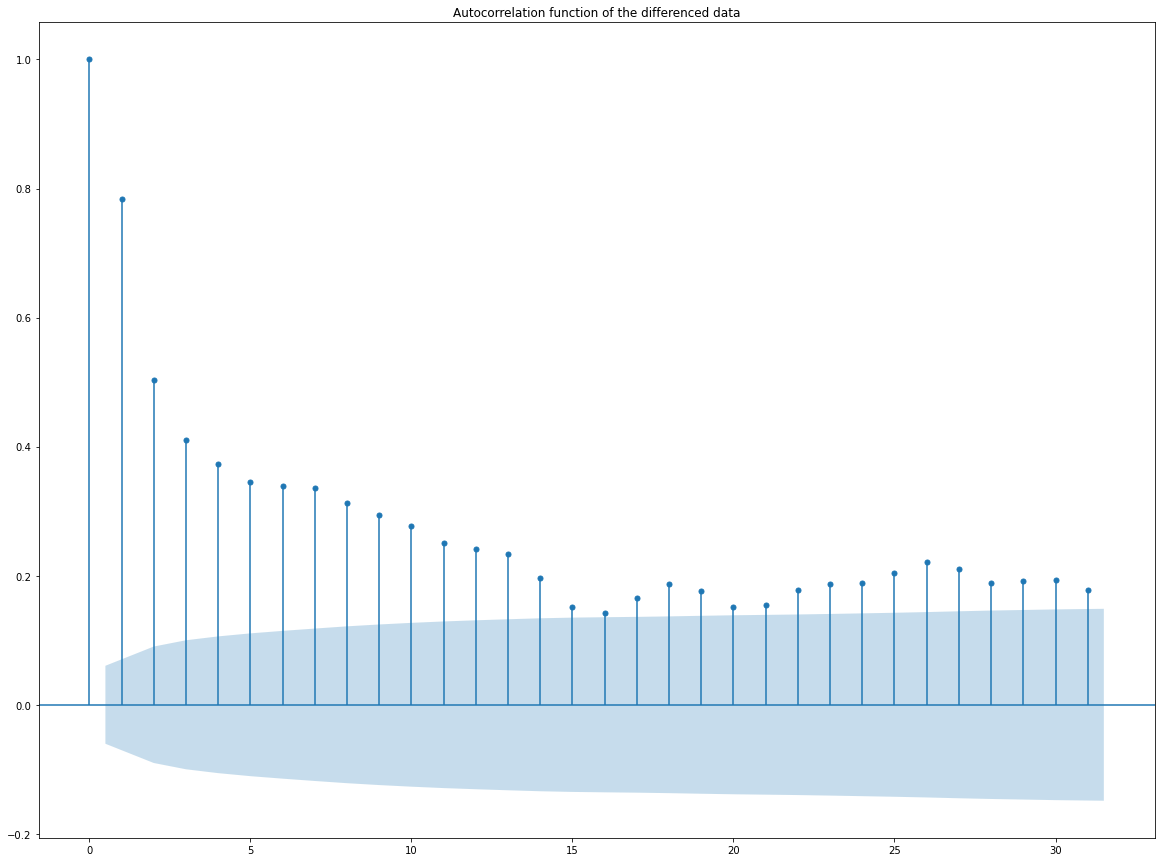

In [181]:
if stationary_check_x == 0:
    # data after differencing
    print(D_data_x)

    # Plot the data after differencing
    D_data_x.plot()
    plt.title(f'Differenced data')
    plt.show()

    # Plot the autocorrelation function after differencing
    plot_acf(D_data_x)
    plt.title(f'Autocorrelation function of the differenced data')
    plt.show()

elif stationary_check_x == 1:
    pass

In [182]:
lbvalue_x = acorr_ljungbox(D_data_x, lags=1)[0][0]
pvalue_wn_x = acorr_ljungbox(D_data_x, lags=1)[1][0]
print(u'lbvalue:', lbvalue_x)
print(u'pvalue:', pvalue_wn_x)

lbvalue: 647.9723209118217
pvalue: 6.167262946745618e-143


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [183]:
white_noise_check_x = 0
if pvalue_wn_x > 0.05:
    white_noise_check_x = 1
    print('Data is white noise series.')
else:
    white_noise_check_x = 0
    print('Data is NOT white noise series.')

Data is NOT white noise series.


In [184]:
if stationary_check_x == 1 and white_noise_check_x == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_x == 0 and white_noise_check_x == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_x == 1 and white_noise_check_x == 0:
    print('Data is stationary and non-white noise series. Use ARMA model.')
elif stationary_check_x == 0 and white_noise_check_x == 0:
    print('Data is non-stationary and non-white noise series. Use ARIMA model.')

Data is non-stationary and non-white noise series. Use ARIMA model.


In [185]:
if stationary_check_x == 1 and white_noise_check_x == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_x == 0 and white_noise_check_x == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_x == 1 and white_noise_check_x == 0:
    order1_x = sm.tsa.arma_order_select_ic(data_df_x, max_ar=6, max_ma=4, ic='aic')['aic_min_order']
    p_x = order1_x[0]
    q_x = order1_x[1]
    model_x = ARMA(data_df_x, order1_x).fit()
    print(model_x.summary2())
elif stationary_check_x == 0 and white_noise_check_x == 0:
    data_df_x[u'Data x'] = data_df_x[u'Data x'].astype(float)
    
    if int(len(D_data_x)/10) > 6:
        pmax_x = 6
        qmax_x = 4
    else:
        pmax_x = int(len(D_data_x)/10)
        qmax_x = int(len(D_data_x)/10)

    bic_matrix_x = []
    for p_x in range(0, pmax_x+1):
        tmp_x = []
        for q_x in range(0, qmax_x+1):
            try:
                tmp_x.append(ARIMA(data_df_x, order=(p_x,k_x,q_x)).fit().bic)
            except Exception as e:
                print(e)
                tmp_x.append(None)
        bic_matrix_x.append(tmp_x)

    bic_matrix_x = pd.DataFrame(bic_matrix_x)
    print('bic_matrix_x: \n', bic_matrix_x)
    print('bic_matrix_stack_x: \n', bic_matrix_x.stack())

    p_x, q_x = bic_matrix_x.stack().idxmin()
    print(u'(p_x, q_x):', (p_x,q_x))
    
    model_x = ARIMA(data_df_x, (p_x, k_x, q_x)).fit()
    print(model_x.summary2())

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmode

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\arden\anaconda3\lib\sit

bic_matrix_x: 
               0             1             2             3             4
0 -19986.668031 -20983.814963 -20702.074221 -21200.086431 -20745.502015
1 -20984.858702 -21245.572105 -21281.521321 -21292.318097 -21288.849971
2 -21066.679232 -21239.746379 -21295.714144 -21289.017672 -21282.003516
3 -21205.106148 -21240.786434 -21286.471964 -21279.566455 -21272.067591
4 -21215.242250 -21238.247508           NaN -21268.861256 -21268.762758
5 -21253.681254 -21247.271314 -21268.910924 -21267.102118 -21262.454547
6 -21246.996926 -21264.349692 -21265.903214 -21251.004571 -21254.490485
bic_matrix_stack_x: 
 0  0   -19986.668031
   1   -20983.814963
   2   -20702.074221
   3   -21200.086431
   4   -20745.502015
1  0   -20984.858702
   1   -21245.572105
   2   -21281.521321
   3   -21292.318097
   4   -21288.849971
2  0   -21066.679232
   1   -21239.746379
   2   -21295.714144
   3   -21289.017672
   4   -21282.003516
3  0   -21205.106148
   1   -21240.786434
   2   -21286.471964
   3   -

In [186]:
if white_noise_check_x == 1:
    pass
elif white_noise_check_x == 0:
    # Forecast result
    data_forecast_x = model_x.forecast(steps=forecast_num_x)[0]
    print('Forecast result:',data_forecast_x)

Forecast result: [-0.75480826 -0.75544884 -0.75608189 -0.7567082  -0.7573282  -0.75794221
 -0.75855051 -0.75915334 -0.75975096 -0.76034358 -0.76093143 -0.76151472
 -0.76209365 -0.76266843 -0.76323923 -0.76380624 -0.76436964 -0.76492958
 -0.76548624 -0.76603976 -0.76659029 -0.76713798 -0.76768296 -0.76822537
 -0.76876533 -0.76930296 -0.76983839 -0.77037172 -0.77090306 -0.77143251
 -0.77196018 -0.77248617 -0.77301055 -0.77353343 -0.77405489 -0.77457501
 -0.77509387 -0.77561154 -0.7761281  -0.77664362 -0.77715816 -0.77767179
 -0.77818457 -0.77869657 -0.77920783 -0.77971842 -0.78022839 -0.78073779
 -0.78124666 -0.78175506 -0.78226303 -0.78277061 -0.78327785 -0.78378478
 -0.78429145 -0.78479789 -0.78530414 -0.78581023 -0.78631619 -0.78682206
 -0.78732787 -0.78783365 -0.78833942 -0.78884521 -0.78935105 -0.78985696
 -0.79036297 -0.7908691  -0.79137538 -0.79188181 -0.79238844 -0.79289526
 -0.79340231 -0.7939096  -0.79441715 -0.79492498 -0.7954331  -0.79594152
 -0.79645027 -0.79695935 -0.797468

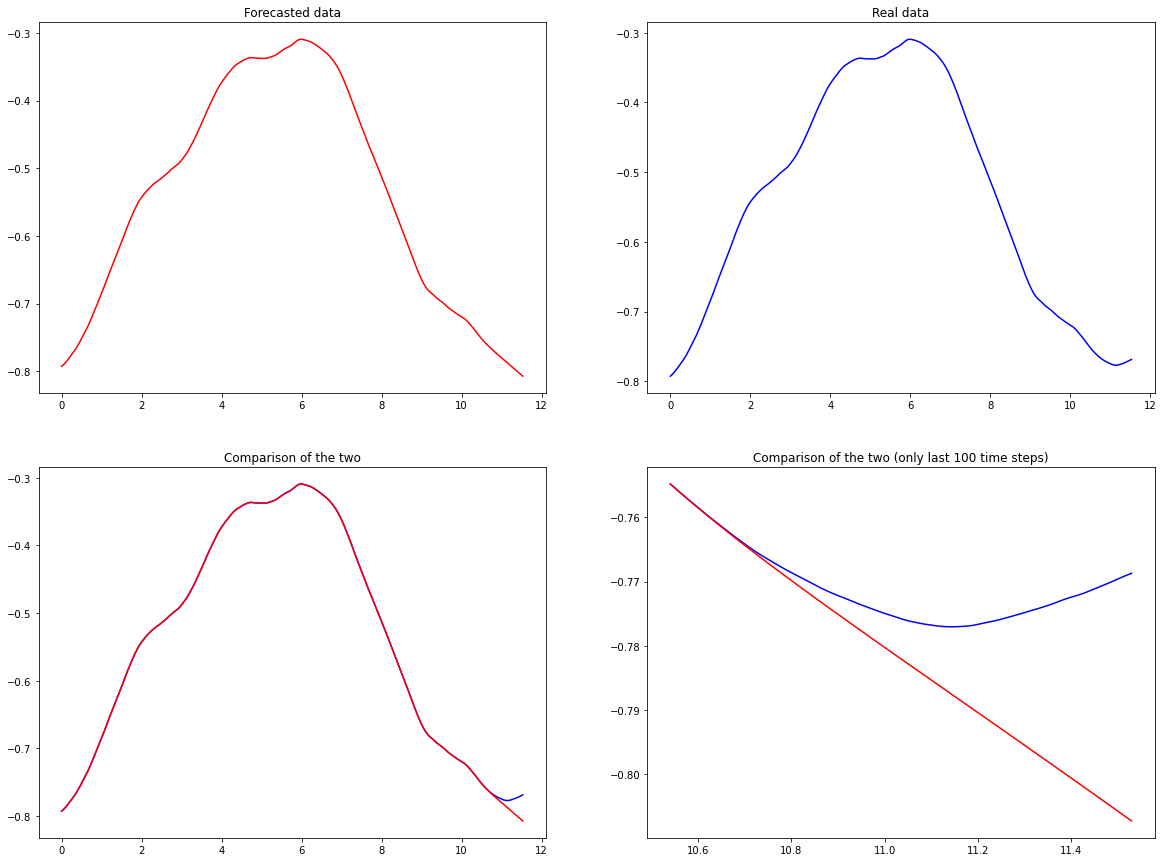

In [187]:
if white_noise_check_x == 1:
    pass
elif white_noise_check_x == 0:
    # Combine forecasted data with the original data
    data_values_x = data_df_x.values.flatten()
    all_data_x = np.block([data_values_x, data_forecast_x])
    # print(all_data)

    # Combine time
    # x_axis = np.linspace(0.00, 1.33, len(all_data))
    # print(x_axis)

    # Plot the combined data
#     plt.plot(t2, all_data, color = 'red')
#     plt.plot(t2, o_x2, color = 'blue')
    plt.rcParams['figure.figsize'] = (20,15)
#     x_ml = plt.MultipleLocator(50)
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(x_ml)
#     plt.title('Combined data')
#     plt.show()
    
    ax1 = plt.subplot(221)
    ax1.plot(t2, all_data_x, color = 'red')
    ax1.set_title('Forecasted data')

    ax2 = plt.subplot(222)
    ax2.plot(t2, o_x2, color = 'blue')
    ax2.set_title('Real data')

    ax3 = plt.subplot(223)
    ax3.plot(t2, o_x2, color = 'blue')
    ax3.plot(t2, all_data_x, color = 'red')
    ax3.set_title('Comparison of the two')
    
    ax4 = plt.subplot(224)
    ax4.plot(t2[-forecast_num_x:], o_x2[-forecast_num_x:], color = 'blue', label = 'Real')
    ax4.plot(t2[-forecast_num_x:], data_forecast_x, color = 'red', label = 'Predicted')
    ax4.set_title(f'Comparison of the two (only last {forecast_num_x} time steps)')
    
    plt.show()

In [188]:
if white_noise_check_x == 1:
    pass
elif white_noise_check_x == 0:
    rmse_x = math.sqrt(mean_squared_error(o_x2[-forecast_num_x:], data_forecast_x))
    print('Root Mean Square Error (RMSE):', rmse_x)

Root Mean Square Error (RMSE): 0.016136871569507126


In [ ]:
#Predicting o_y

In [204]:
# define number of time steps to forecast
forecast_num_y = 100

# define time step
time_step = 0.01

# t minimum offset
tmin = 35

# t maximum offset
tmax = 35

In [205]:
# data for forecasting
data = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t = data['time']
# position
o_y = data['ae483log.o_y']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']
print(o_y)

data_matrix_y = {}
data_matrix_y['Datatime'] = t
data_matrix_y['Data y'] = o_y
data_df_y = pd.DataFrame(data_matrix_y)
data_df_y = data_df_y.set_index('Datatime')

# real data
data2 = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax-time_step*forecast_num,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t2 = data2['time']
# position
o_y2 = data2['ae483log.o_y']
o_y2 = data2['ae483log.o_y']
o_z2 = data2['ae483log.o_z']

data2_matrix_y = {}
data2_matrix_y['Datatime'] = t2
data2_matrix_y['Data y'] = o_y2
data_df2_y = pd.DataFrame(data2_matrix_y)
data_df2_y = data_df2_y.set_index('Datatime')

[0.0428045  0.04222313 0.04162111 ... 0.45061708 0.45033207 0.45002344]


In [206]:
data_df_y

,Data y
Datatime,
0.00,0.042804
0.01,0.042223
0.02,0.041621
0.03,0.040993
0.04,0.040336
...,...
10.49,0.451151
10.50,0.450888
10.51,0.450617


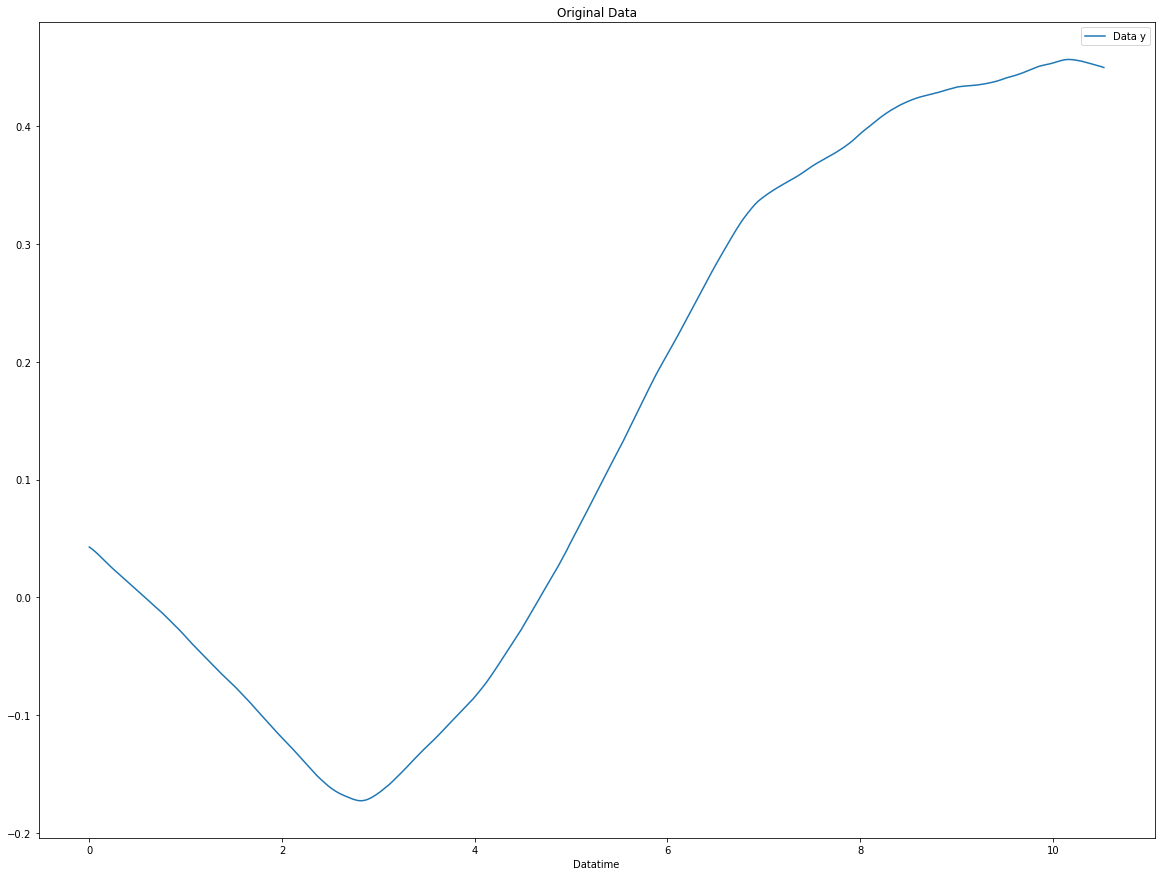

In [207]:
data_df_y.plot()
plt.title('Original Data')
plt.show()

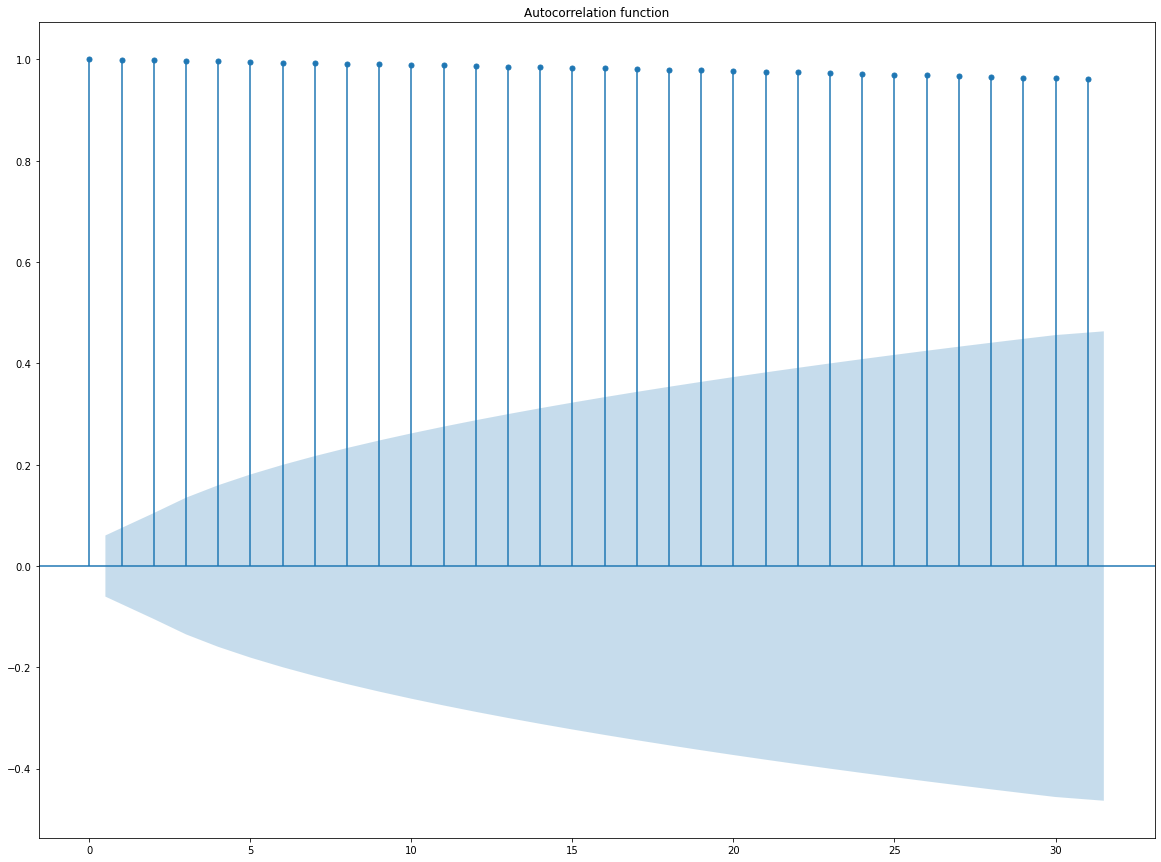

In [208]:
plot_acf(data_df_y)
plt.title('Autocorrelation function')
plt.show()

In [209]:
print(u'adf:', ADF(data_df_y[u'Data y'])[0])
print(u'pvalue:', ADF(data_df_y[u'Data y'])[1])
print(u'critical values:', ADF(data_df_y[u'Data y'])[4])

# extract stationarity check result
adf_y = ADF(data_df_y[u'Data y'])[0]
pvalue_y = ADF(data_df_y[u'Data y'])[1]
critical_values_y = ADF(data_df_y[u'Data y'])[4]
cv1_y = critical_values_y['1%']
cv5_y = critical_values_y['5%']
cv10_y = critical_values_y['10%']

adf: -2.826569819074143
pvalue: 0.05457754328261935
critical values: {'1%': -3.436647308529461, '5%': -2.864320407484321, '10%': -2.568250401889486}


In [210]:
# k is the number of difference that we need to do
k_y = 0

# define stationary check (1 means stationary, 0 means non-stationary)
stationary_check_y = 0

# keep differencing the data until it becomes stationary
D_data_y = data_df_y
while True:
    if pvalue_y >= 0.05:
        D_data_y = D_data_y.diff().dropna()
        k_y += 1
        adf_y = ADF(D_data_y[u'Data y'])[0]
        pvalue_y = ADF(D_data_y[u'Data y'])[1]
        critical_values_y = ADF(D_data_y[u'Data y'])[4]
        cv1_y = critical_values_y['1%']
        cv5_y = critical_values_y['5%']
        cv10_y = critical_values_y['10%']
        continue
    else:
        break

if k_y == 0:
    stationary_check_y = 1
    print('The orginal data is STATIONARY, no differencing needed')
    print(u'adf:', adf_y)
    print(u'pvalue:', pvalue_y)
    print(u'critical values:', critical_values_y)
else:
    stationary_check_y = 0
    print(f'The orginal data is NON-STATIONARY, need to do differencing {k} times')
    print(f'adf:', adf_y)
    print(f'pvalue:', pvalue_y)
    print(f'critical values:', critical_values_y)

The orginal data is NON-STATIONARY, need to do differencing 2 times
adf: -5.89576068509956
pvalue: 2.854052179765047e-07
critical values: {'1%': -3.436647308529461, '5%': -2.864320407484321, '10%': -2.568250401889486}


            Data y
Datatime          
0.02     -0.000021
0.03     -0.000026
0.04     -0.000029
0.05     -0.000031
0.06     -0.000026
...            ...
10.49    -0.000008
10.50     0.000001
10.51    -0.000008
10.52    -0.000014
10.53    -0.000024

[1052 rows x 1 columns]


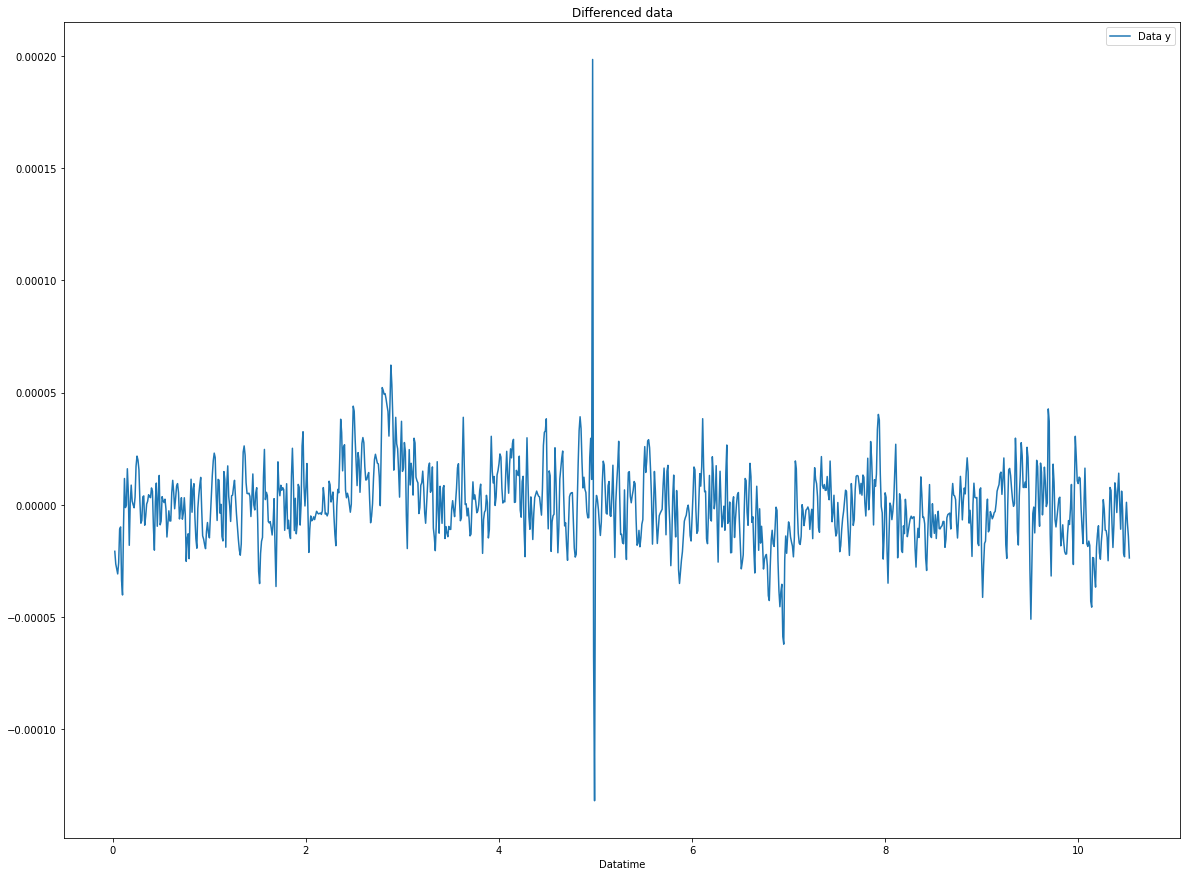

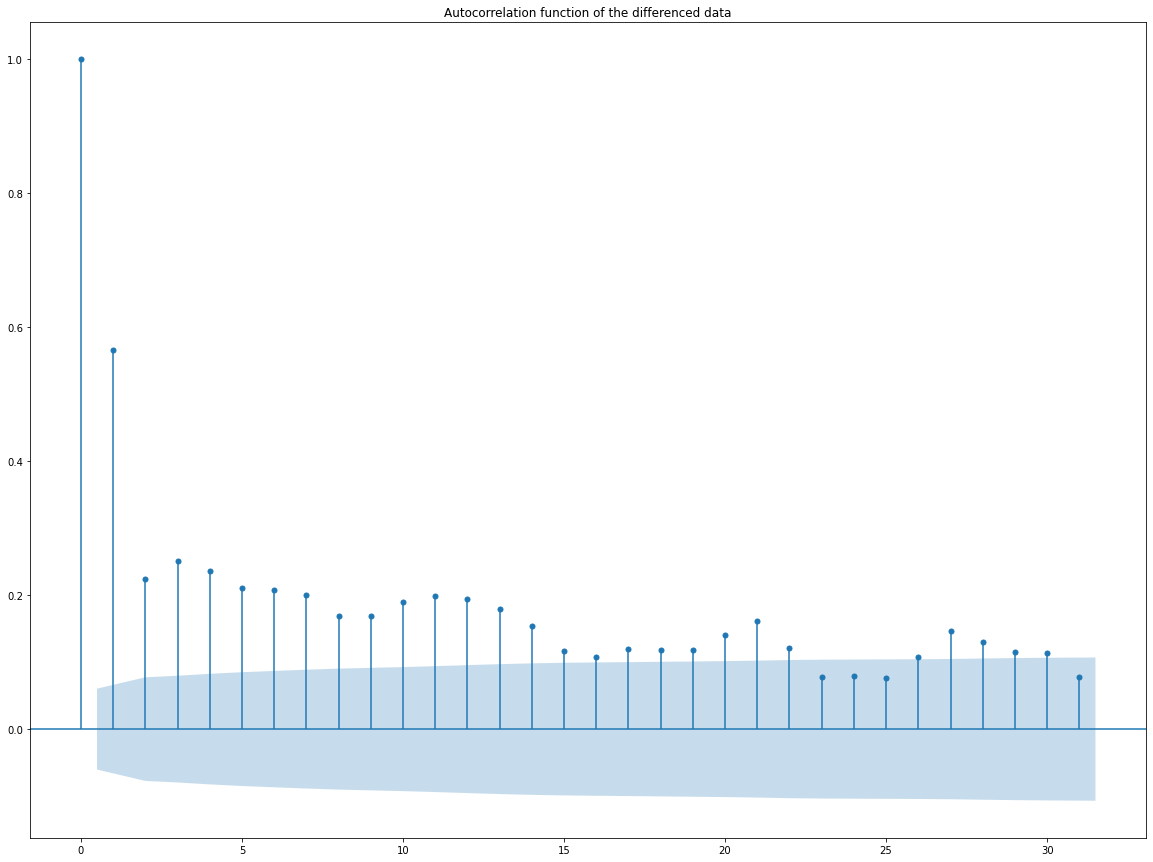

In [211]:
if stationary_check_y == 0:
    # data after differencing
    print(D_data_y)

    # Plot the data after differencing
    D_data_y.plot()
    plt.title(f'Differenced data')
    plt.show()

    # Plot the autocorrelation function after differencing
    plot_acf(D_data_y)
    plt.title(f'Autocorrelation function of the differenced data')
    plt.show()

elif stationary_check_y == 1:
    pass

In [212]:
lbvalue_y = acorr_ljungbox(D_data_y, lags=1)[0][0]
pvalue_wn_y = acorr_ljungbox(D_data_y, lags=1)[1][0]
print(u'lbvalue:', lbvalue_y)
print(u'pvalue:', pvalue_wn_y)

lbvalue: 337.68948053366796
pvalue: 2.0326640568228308e-75


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [213]:
white_noise_check_y = 0
if pvalue_wn_y > 0.05:
    white_noise_check_y = 1
    print('Data is white noise series.')
else:
    white_noise_check_y = 0
    print('Data is NOT white noise series.')

Data is NOT white noise series.


In [214]:
if stationary_check_y == 1 and white_noise_check_y == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_y == 0 and white_noise_check_y == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_y == 1 and white_noise_check_y == 0:
    print('Data is stationary and non-white noise series. Use ARMA model.')
elif stationary_check_y == 0 and white_noise_check_y == 0:
    print('Data is non-stationary and non-white noise series. Use ARIMA model.')

Data is non-stationary and non-white noise series. Use ARIMA model.


In [215]:
if stationary_check_y == 1 and white_noise_check_y == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_y == 0 and white_noise_check_y == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_y == 1 and white_noise_check_y == 0:
    order1_y = sm.tsa.arma_order_select_ic(data_df_y, max_ar=6, max_ma=4, ic='aic')['aic_min_order']
    p_y = order1_y[0]
    q_y = order1_y[1]
    model_y = ARMA(data_df_y, order1_y).fit()
    print(model_y.summary2())
elif stationary_check_y == 0 and white_noise_check_y == 0:
    data_df_y[u'Data y'] = data_df_y[u'Data y'].astype(float)
    
    if int(len(D_data_y)/10) > 6:
        pmax_y = 6
        qmax_y = 4
    else:
        pmax_y = int(len(D_data_y)/10)
        qmax_y = int(len(D_data_y)/10)

    bic_matrix_y = []
    for p_y in range(0, pmax_y+1):
        tmp_y = []
        for q_y in range(0, qmax_y+1):
            try:
                tmp_y.append(ARIMA(data_df_y, order=(p_y,k_y,q_y)).fit().bic)
            except Exception as e:
                print(e)
                tmp_y.append(None)
        bic_matrix_y.append(tmp_y)

    bic_matrix_y = pd.DataFrame(bic_matrix_y)
    print('bic_matrix_y: \n', bic_matrix_y)
    print('bic_matrix_stack_y: \n', bic_matrix_y.stack())

    p_y, q_y = bic_matrix_y.stack().idxmin()
    print(u'(p_y, q_y):', (p_y,q_y))
    
    model_y = ARIMA(data_df_y, (p_y, k_y, q_y)).fit()
    print(model_y.summary2())

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:57

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
bic_matrix_y: 
               0             1             2             3             4
0 -20037.326362 -20505.071371 -20412.999899 -20507.867478 -20513.652273
1 -20437.370674 -20484.642723 -20565.441902 -20563.298391 -20555.788459
2 -20451.417305 -20505.485719 -20564.045815 -20556.534811 -20549.190976
3 -20531.360098 -20527.233201 -20556.139615 -20548.549541 -20543.186625
4 -20525.803318 -20519.835697 -20550.158484 -20542.653422 -20536.466902
5 -20539.296241 -20533.422360 -20541.579638 -20537.136754           NaN
6 -20532.869658 -20525.532472 -20530.876652 -20522.979680           NaN
bic_matrix_stack_y: 
 0  0   -20037.326362
   1   -20505.071371
   2   -20412.999899
   3   -20507.867478
   4   -20513.652273
1  0   -20437.370674
   1   -20484.642723
   2   -20565.441902
   3   -20563.298391
   4   -20555.788459
2  0   -20451.417

In [216]:
if white_noise_check_y == 1:
    pass
elif white_noise_check_y == 0:
    # Forecast result
    data_forecast_y = model_y.forecast(steps=forecast_num_y)[0]
    print('Forecast result:',data_forecast_y)

Forecast result: [0.44969851 0.44936598 0.44902591 0.44867836 0.44832341 0.44796113
 0.44759157 0.44721481 0.44683092 0.44643995 0.44604197 0.44563705
 0.44522525 0.44480662 0.44438124 0.44394915 0.44351043 0.44306513
 0.44261331 0.44215502 0.44169034 0.4412193  0.44074197 0.44025841
 0.43976866 0.43927279 0.43877085 0.43826289 0.43774896 0.43722912
 0.43670342 0.4361719  0.43563463 0.43509164 0.43454299 0.43398874
 0.43342891 0.43286357 0.43229277 0.43171654 0.43113494 0.43054801
 0.42995579 0.42935834 0.42875569 0.42814789 0.42753498 0.42691701
 0.42629402 0.42566605 0.42503314 0.42439534 0.42375268 0.42310521
 0.42245296 0.42179597 0.42113429 0.42046795 0.41979699 0.41912145
 0.41844136 0.41775677 0.41706771 0.41637421 0.41567631 0.41497405
 0.41426746 0.41355658 0.41284143 0.41212207 0.41139851 0.41067079
 0.40993895 0.40920301 0.40846301 0.40771899 0.40697097 0.40621898
 0.40546305 0.40470322 0.40393952 0.40317197 0.40240061 0.40162546
 0.40084655 0.40006391 0.39927758 0.39848757 

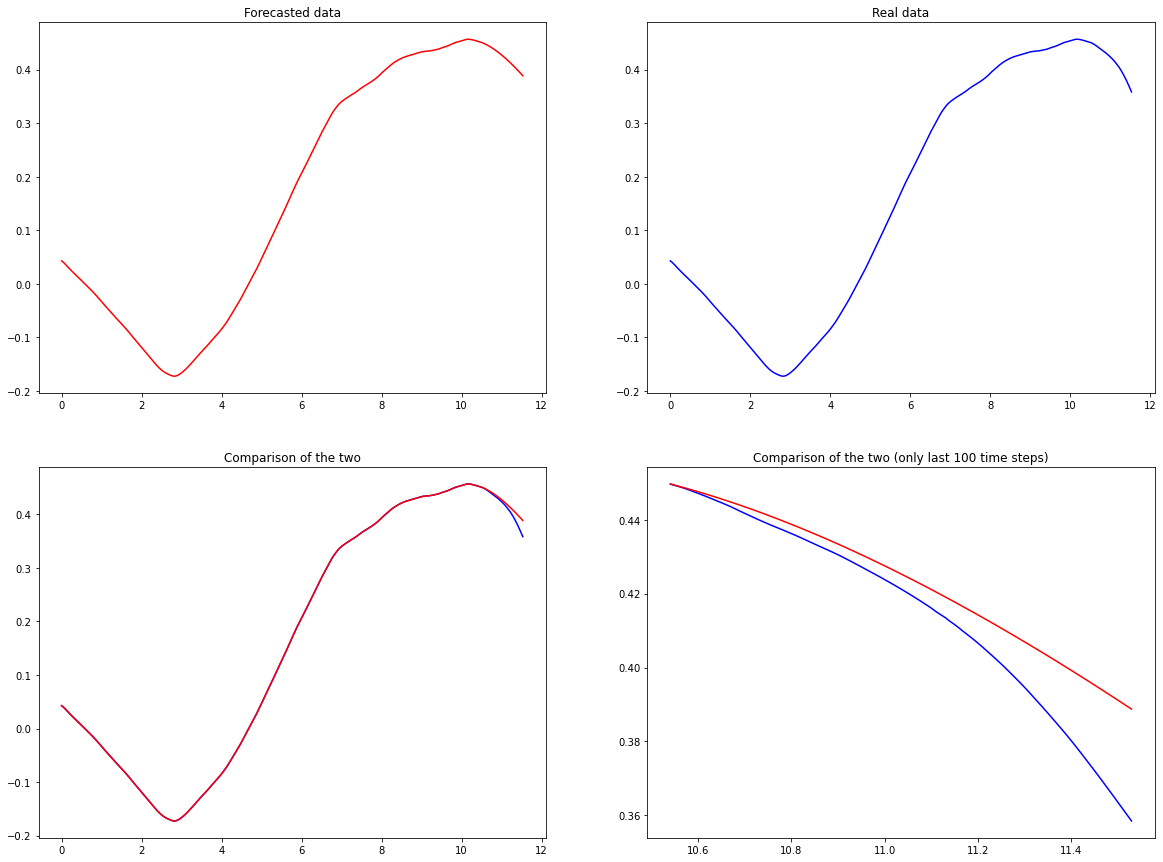

In [217]:
if white_noise_check_y == 1:
    pass
elif white_noise_check_y == 0:
    # Combine forecasted data with the original data
    data_values_y = data_df_y.values.flatten()
    all_data_y = np.block([data_values_y, data_forecast_y])
    # print(all_data)

    # Combine time
    # y_axis = np.linspace(0.00, 1.33, len(all_data))
    # print(x_axis)

    # Plot the combined data
#     plt.plot(t2, all_data, color = 'red')
#     plt.plot(t2, o_y2, color = 'blue')
    plt.rcParams['figure.figsize'] = (20,15)
#     y_ml = plt.MultipleLocator(50)
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(x_ml)
#     plt.title('Combined data')
#     plt.show()
    
    ax1 = plt.subplot(221)
    ax1.plot(t2, all_data_y, color = 'red')
    ax1.set_title('Forecasted data')

    ax2 = plt.subplot(222)
    ax2.plot(t2, o_y2, color = 'blue')
    ax2.set_title('Real data')

    ax3 = plt.subplot(223)
    ax3.plot(t2, o_y2, color = 'blue')
    ax3.plot(t2, all_data_y, color = 'red')
    ax3.set_title('Comparison of the two')
    
    ax4 = plt.subplot(224)
    ax4.plot(t2[-forecast_num_y:], o_y2[-forecast_num_y:], color = 'blue', label = 'Real')
    ax4.plot(t2[-forecast_num_y:], data_forecast_y, color = 'red', label = 'Predicted')
    ax4.set_title(f'Comparison of the two (only last {forecast_num_y} time steps)')
    
    plt.show()

In [218]:
if white_noise_check_y == 1:
    pass
elif white_noise_check_y == 0:
    rmse_y = math.sqrt(mean_squared_error(o_y2[-forecast_num_y:], data_forecast_y))
    print('Root Mean Square Error (RMSE):', rmse_y)

Root Mean Square Error (RMSE): 0.01125495754839199


In [ ]:
#Predicting o_z

In [219]:
# define number of time steps to forecast
forecast_num_z = 100

# define time step
time_step = 0.01

# t minimum offset
tmin = 35

# t maximum offset
tmax = 35

In [220]:
# data for forecasting
data = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t = data['time']
# position
o_z = data['ae483log.o_z']
o_z = data['ae483log.o_z']
o_z = data['ae483log.o_z']
print(o_z)

data_matrix_z = {}
data_matrix_z['Datatime'] = t
data_matrix_z['Data z'] = o_z
data_df_z = pd.DataFrame(data_matrix_z)
data_df_z = data_df_z.set_index('Datatime')

# real data
data2 = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=tmin,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=tmax-time_step*forecast_num,      # <-- (optional) replace with how many seconds of data to ignore at end
)
# time
t2 = data2['time']
# position
o_z2 = data2['ae483log.o_z']
o_z2 = data2['ae483log.o_z']
o_z2 = data2['ae483log.o_z']

data2_matrix_z = {}
data2_matrix_z['Datatime'] = t2
data2_matrix_z['Data z'] = o_z2
data_df2_z = pd.DataFrame(data2_matrix_z)
data_df2_z = data_df2_z.set_index('Datatime')

[0.6012838  0.60090302 0.60076556 ... 0.57337852 0.57338603 0.5725895 ]


In [221]:
data_df_z

,Data z
Datatime,
0.00,0.601284
0.01,0.600903
0.02,0.600766
0.03,0.600795
0.04,0.601496
...,...
10.49,0.568549
10.50,0.572103
10.51,0.573379


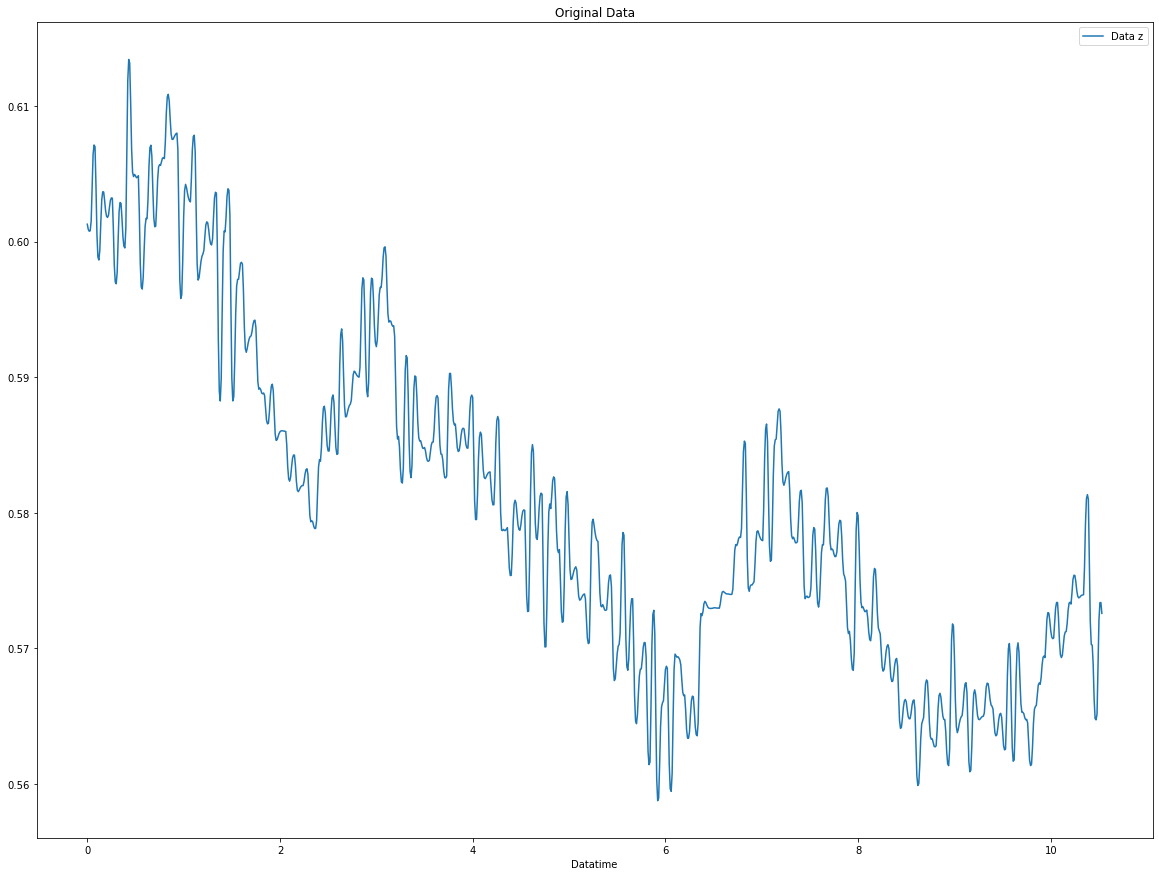

In [222]:
data_df_z.plot()
plt.title('Original Data')
plt.show()

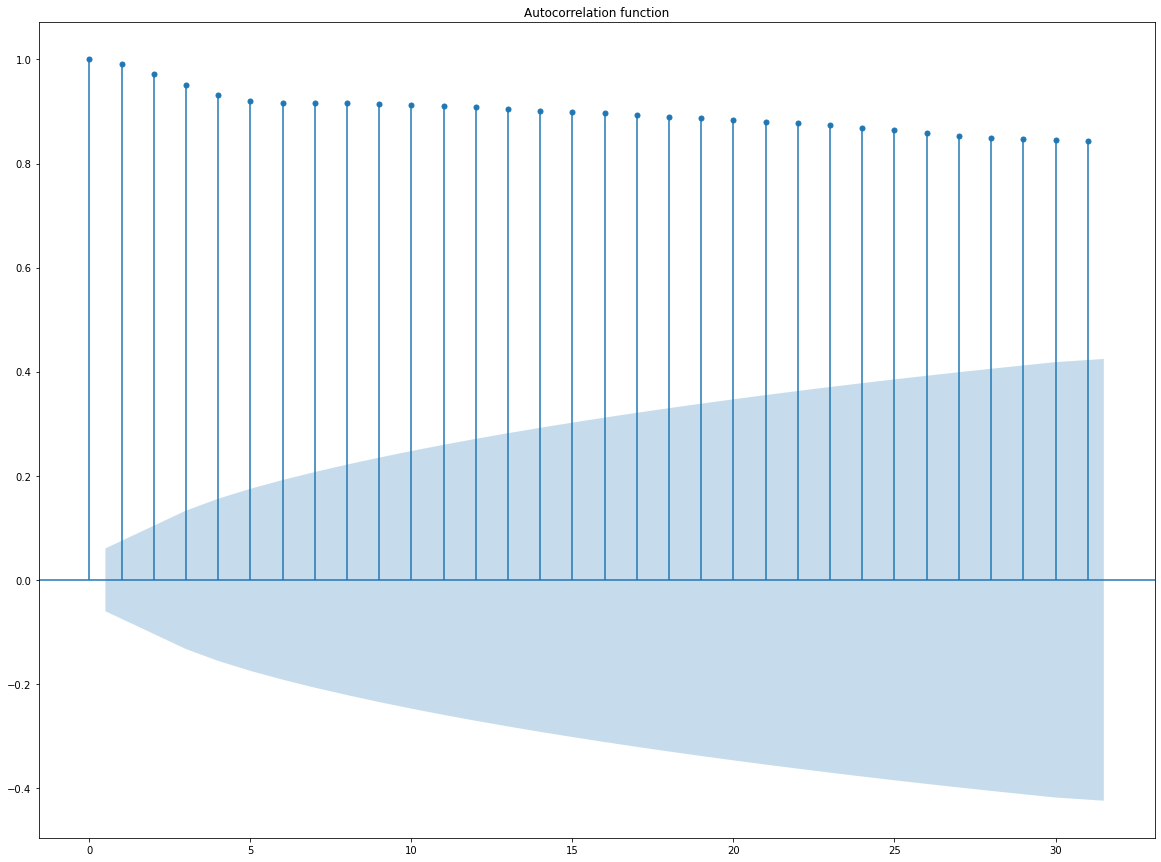

In [223]:
plot_acf(data_df_z)
plt.title('Autocorrelation function')
plt.show()

In [224]:
print(u'adf:', ADF(data_df_z[u'Data z'])[0])
print(u'pvalue:', ADF(data_df_z[u'Data z'])[1])
print(u'critical values:', ADF(data_df_z[u'Data z'])[4])

# extract stationarity check result
adf_z = ADF(data_df_z[u'Data z'])[0]
pvalue_z = ADF(data_df_z[u'Data z'])[1]
critical_values_z = ADF(data_df_z[u'Data z'])[4]
cv1_z = critical_values_z['1%']
cv5_z = critical_values_z['5%']
cv10_z = critical_values_z['10%']

adf: -1.6792967271872015
pvalue: 0.4418097490699612
critical values: {'1%': -3.436647308529461, '5%': -2.864320407484321, '10%': -2.568250401889486}


In [225]:
# k is the number of difference that we need to do
k_z = 0

# define stationary check (1 means stationary, 0 means non-stationary)
stationary_check_z = 0

# keep differencing the data until it becomes stationary
D_data_z = data_df_z
while True:
    if pvalue_z >= 0.05:
        D_data_z = D_data_z.diff().dropna()
        k_z += 1
        adf_z = ADF(D_data_z[u'Data z'])[0]
        pvalue_z = ADF(D_data_z[u'Data z'])[1]
        critical_values_z = ADF(D_data_z[u'Data z'])[4]
        cv1_z = critical_values_z['1%']
        cv5_z = critical_values_z['5%']
        cv10_z = critical_values_z['10%']
        continue
    else:
        break

if k_z == 0:
    stationary_check_z = 1
    print('The orginal data is STATIONARY, no differencing needed')
    print(u'adf:', adf_z)
    print(u'pvalue:', pvalue_z)
    print(u'critical values:', critical_values_z)
else:
    stationary_check_z = 0
    print(f'The orginal data is NON-STATIONARY, need to do differencing {k} times')
    print(f'adf:', adf_z)
    print(f'pvalue:', pvalue_z)
    print(f'critical values:', critical_values_z)

The orginal data is NON-STATIONARY, need to do differencing 2 times
adf: -13.288717507858
pvalue: 7.437258626148028e-25
critical values: {'1%': -3.436647308529461, '5%': -2.864320407484321, '10%': -2.568250401889486}


            Data z
Datatime          
0.01     -0.000381
0.02     -0.000137
0.03      0.000030
0.04      0.000701
0.05      0.002617
...            ...
10.49     0.003390
10.50     0.003554
10.51     0.001276
10.52     0.000008
10.53    -0.000797

[1053 rows x 1 columns]


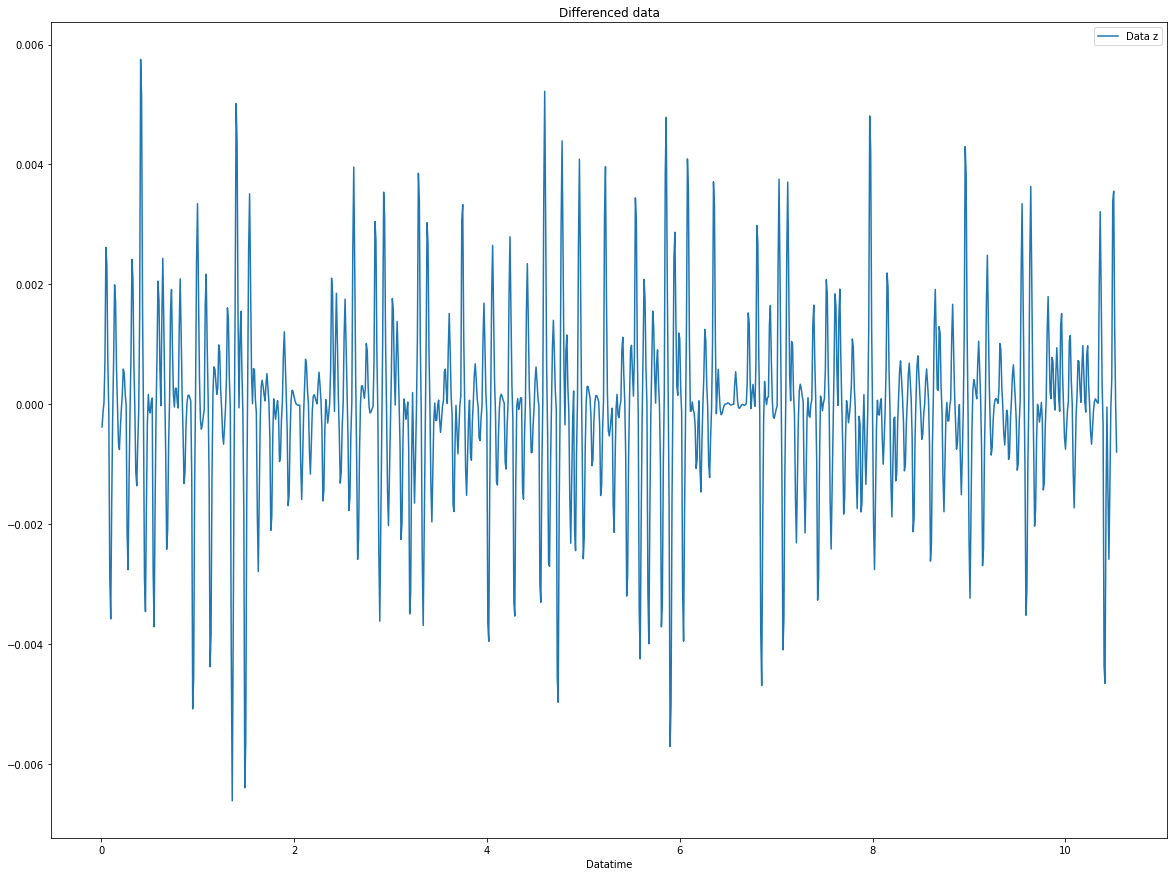

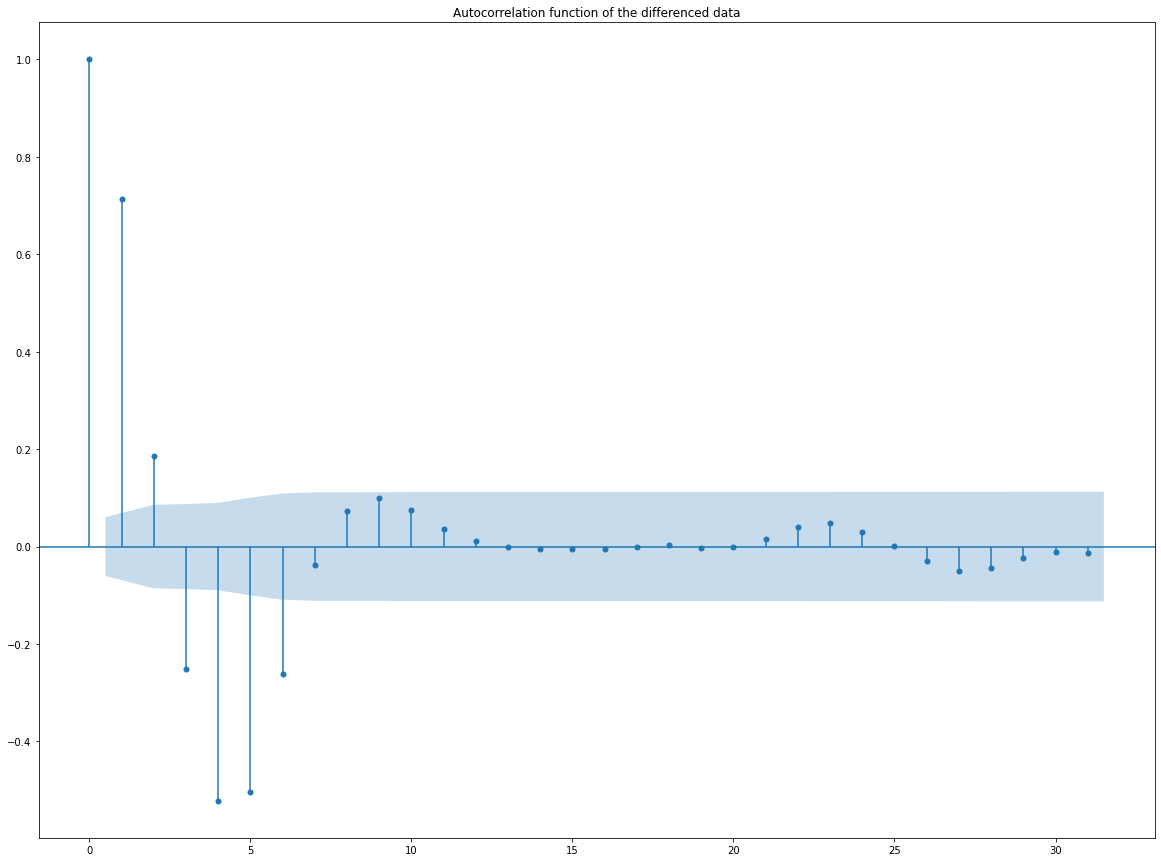

In [226]:
if stationary_check_z == 0:
    # data after differencing
    print(D_data_z)

    # Plot the data after differencing
    D_data_z.plot()
    plt.title(f'Differenced data')
    plt.show()

    # Plot the autocorrelation function after differencing
    plot_acf(D_data_z)
    plt.title(f'Autocorrelation function of the differenced data')
    plt.show()

elif stationary_check_z == 1:
    pass

In [227]:
lbvalue_z = acorr_ljungbox(D_data_z, lags=1)[0][0]
pvalue_wn_z = acorr_ljungbox(D_data_z, lags=1)[1][0]
print(u'lbvalue:', lbvalue_z)
print(u'pvalue:', pvalue_wn_z)

lbvalue: 537.5049717874944
pvalue: 6.579955233396213e-119


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [228]:
white_noise_check_z = 0
if pvalue_wn_z > 0.05:
    white_noise_check_z = 1
    print('Data is white noise series.')
else:
    white_noise_check_z = 0
    print('Data is NOT white noise series.')

Data is NOT white noise series.


In [229]:
if stationary_check_z == 1 and white_noise_check_z == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_z == 0 and white_noise_check_z == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_z == 1 and white_noise_check_z == 0:
    print('Data is stationary and non-white noise series. Use ARMA model.')
elif stationary_check_z == 0 and white_noise_check_z == 0:
    print('Data is non-stationary and non-white noise series. Use ARIMA model.')

Data is non-stationary and non-white noise series. Use ARIMA model.


In [230]:
if stationary_check_z == 1 and white_noise_check_z == 1:
    print('Data is stationary and white noise series. Experiment Failed.')
elif stationary_check_z == 0 and white_noise_check_z == 1:
    print('Data is non-stationary and white noise series. Experiment Failed.')
elif stationary_check_z == 1 and white_noise_check_z == 0:
    order1_z = sm.tsa.arma_order_select_ic(data_df_z, max_ar=6, max_ma=4, ic='aic')['aic_min_order']
    p_z = order1_z[0]
    q_z = order1_z[1]
    model_z = ARMA(data_df_z, order1_z).fit()
    print(model_z.summary2())
elif stationary_check_z == 0 and white_noise_check_z == 0:
    data_df_z[u'Data z'] = data_df_z[u'Data z'].astype(float)
    
    if int(len(D_data_z)/10) > 6:
        pmax_z = 6
        qmax_z = 4
    else:
        pmax_z = int(len(D_data_z)/10)
        qmax_z = int(len(D_data_z)/10)

    bic_matrix_z = []
    for p_z in range(0, pmax_z+1):
        tmp_z = []
        for q_z in range(0, qmax_z+1):
            try:
                tmp_z.append(ARIMA(data_df_z, order=(p_z,k_z,q_z)).fit().bic)
            except Exception as e:
                print(e)
                tmp_z.append(None)
        bic_matrix_z.append(tmp_z)

    bic_matrix_z = pd.DataFrame(bic_matrix_z)
    print('bic_matrix_z: \n', bic_matrix_z)
    print('bic_matrix_stack_z: \n', bic_matrix_z.stack())

    p_z, q_z = bic_matrix_z.stack().idxmin()
    print(u'(p_z, q_z):', (p_z,q_z))
    
    model_z = ARIMA(data_df_z, (p_z, k_z, q_z)).fit()
    print(model_z.summary2())

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmode

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\arden\anaconda3\lib\site-packages\statsmode

bic_matrix_z: 
               0             1             2             3             4
0 -10673.914316 -11690.686260 -12024.519553 -12029.831738 -12103.521874
1 -11415.579058 -11992.425963 -12035.267176 -12065.860367           NaN
2 -12007.075917 -12065.524504 -12206.912937 -12203.018018 -12198.007517
3 -12000.123039 -12111.429532 -12202.943140 -12196.145313 -12222.517489
4 -12150.714933 -12250.919508 -12259.285751 -12261.489855 -12265.029572
5 -12237.237316 -12257.673618 -12253.761727 -12266.920100 -12289.208969
6 -12277.289899 -12303.320227 -12296.596890 -12289.635291 -12297.950302
bic_matrix_stack_z: 
 0  0   -10673.914316
   1   -11690.686260
   2   -12024.519553
   3   -12029.831738
   4   -12103.521874
1  0   -11415.579058
   1   -11992.425963
   2   -12035.267176
   3   -12065.860367
2  0   -12007.075917
   1   -12065.524504
   2   -12206.912937
   3   -12203.018018
   4   -12198.007517
3  0   -12000.123039
   1   -12111.429532
   2   -12202.943140
   3   -12196.145313
   4   -

C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\arden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

                           Results: ARIMA
Model:              ARIMA            BIC:                 -12303.3202
Dependent Variable: D.Data z         Log-Likelihood:      6183.0     
Date:               2022-11-11 20:16 Scale:               1.0000     
No. Observations:   1053             Method:              css-mle    
Df Model:           8                Sample:              1          
Df Residuals:       1045                                  4          
Converged:          1.0000           S.D. of innovations: 0.001      
No. Iterations:     12.0000          HQIC:                -12331.033 
AIC:                -12347.9548                                      
----------------------------------------------------------------------
                  Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
----------------------------------------------------------------------
const            -0.0000    0.0000   -1.2030  0.2290  -0.0001   0.0000
ar.L1.D.Data z    1.9857    0.0692   28.6809

In [231]:
if white_noise_check_z == 1:
    pass
elif white_noise_check_z == 0:
    # Forecast result
    data_forecast_z = model_z.forecast(steps=forecast_num_z)[0]
    print('Forecast result:',data_forecast_z)

Forecast result: [0.57102921 0.57004712 0.5699032  0.56983554 0.5698429  0.56984863
 0.56954803 0.56927316 0.56930508 0.56948463 0.56977366 0.57010022
 0.57022826 0.57014905 0.56998993 0.56978991 0.56962562 0.56956317
 0.56954773 0.56953217 0.56951578 0.56948067 0.5694345  0.56941046
 0.5694071  0.569409   0.5694098  0.56939461 0.56935604 0.56930643
 0.56925627 0.5692109  0.56917589 0.56914884 0.56912279 0.56909553
 0.56906663 0.5690361  0.56900639 0.56897873 0.56895164 0.56892392
 0.56889472 0.56886336 0.56883066 0.56879808 0.56876629 0.56873562
 0.5687059  0.56867645 0.56864677 0.56861683 0.56858669 0.5685565
 0.56852647 0.56849651 0.56846648 0.56843629 0.56840592 0.56837542
 0.56834494 0.56831457 0.56828433 0.56825419 0.56822408 0.56819395
 0.56816378 0.56813357 0.56810335 0.56807314 0.56804294 0.56801273
 0.56798251 0.56795228 0.56792203 0.56789179 0.56786156 0.56783134
 0.56780114 0.56777093 0.56774073 0.56771052 0.5676803  0.56765008
 0.56761987 0.56758965 0.56755943 0.56752922 0

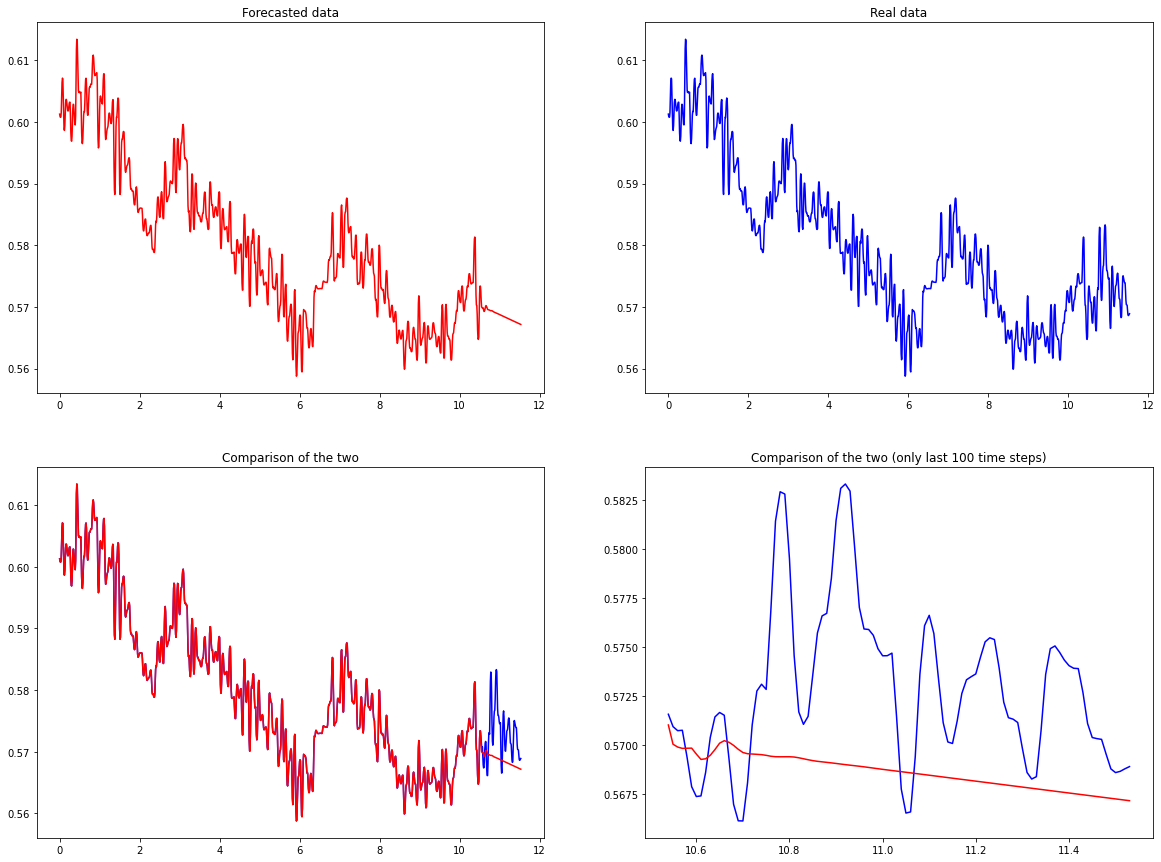

In [232]:
if white_noise_check_z == 1:
    pass
elif white_noise_check_z == 0:
    # Combine forecasted data with the original data
    data_values_z = data_df_z.values.flatten()
    all_data_z = np.block([data_values_z, data_forecast_z])
    # print(all_data)

    # Combine time
    # z_axis = np.linspace(0.00, 1.33, len(all_data))
    # print(x_axis)

    # Plot the combined data
#     plt.plot(t2, all_data, color = 'red')
#     plt.plot(t2, o_z2, color = 'blue')
    plt.rcParams['figure.figsize'] = (20,15)
#     z_ml = plt.MultipleLocator(50)
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(x_ml)
#     plt.title('Combined data')
#     plt.show()
    
    ax1 = plt.subplot(221)
    ax1.plot(t2, all_data_z, color = 'red')
    ax1.set_title('Forecasted data')

    ax2 = plt.subplot(222)
    ax2.plot(t2, o_z2, color = 'blue')
    ax2.set_title('Real data')

    ax3 = plt.subplot(223)
    ax3.plot(t2, o_z2, color = 'blue')
    ax3.plot(t2, all_data_z, color = 'red')
    ax3.set_title('Comparison of the two')
    
    ax4 = plt.subplot(224)
    ax4.plot(t2[-forecast_num_z:], o_z2[-forecast_num_z:], color = 'blue', label = 'Real')
    ax4.plot(t2[-forecast_num_z:], data_forecast_z, color = 'red', label = 'Predicted')
    ax4.set_title(f'Comparison of the two (only last {forecast_num_z} time steps)')
    
    plt.show()

In [233]:
if white_noise_check_z == 1:
    pass
elif white_noise_check_z == 0:
    rmse_z = math.sqrt(mean_squared_error(o_z2[-forecast_num_z:], data_forecast_z))
    print('Root Mean Square Error (RMSE):', rmse_z)

Root Mean Square Error (RMSE): 0.005840444165209934


In [ ]:
#3D plotting

Text(0.5, 0.92, 'Real Data')

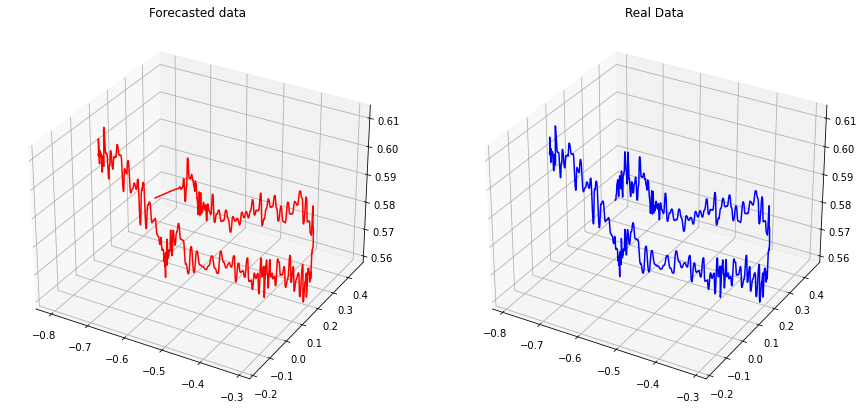

In [249]:
fig_3d = plt.figure(figsize=plt.figaspect(1))

ax1_3d = fig_3d.add_subplot(1, 2, 1, projection='3d')
ax1_3d.plot3D(all_data_x, all_data_y, all_data_z, 'red')
ax1_3d.set_title('Forecasted data')

ax2_3d = fig_3d.add_subplot(1, 2, 2, projection='3d')
ax2_3d.plot3D(o_x2, o_y2, o_z2, 'blue')
ax2_3d.set_title('Real Data')

Text(0.5, 0.92, 'Comparison of the two (only last 100 time steps)')

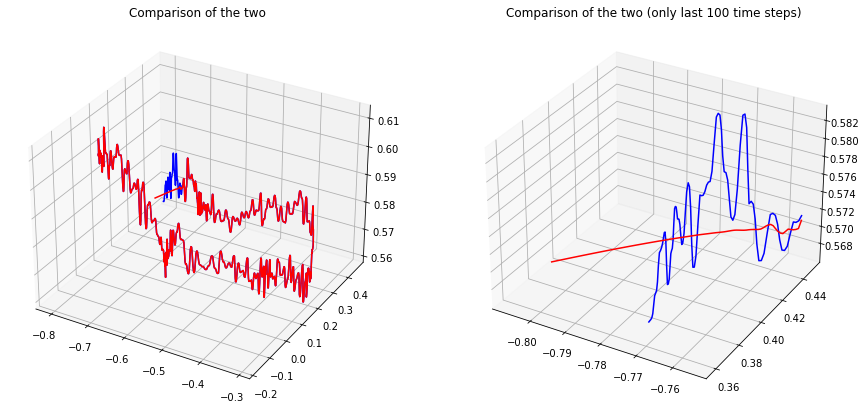

In [248]:
fig_3d_comp = plt.figure(figsize=plt.figaspect(1))

ax3_3d = fig_3d_comp.add_subplot(1, 2, 1, projection='3d')
ax3_3d.plot3D(o_x2, o_y2, o_z2, 'blue')
ax3_3d.plot3D(all_data_x, all_data_y, all_data_z, 'red')
ax3_3d.set_title('Comparison of the two')

ax4_3d = fig_3d_comp.add_subplot(1, 2, 2, projection='3d')
ax4_3d.plot3D(o_x2[-forecast_num_x:], o_y2[-forecast_num_y:], o_z2[-forecast_num_z:], 'blue')
ax4_3d.plot3D(data_forecast_x, data_forecast_y, data_forecast_z, 'red')
ax4_3d.set_title(f'Comparison of the two (only last {forecast_num_z} time steps)')

## Reference:
https://blog.csdn.net/watermelon12138/article/details/86611444

https://zhuanlan.zhihu.com/p/54985638